## Multilabel classification on offensive social media post with BERT and PyTorch Lightning
#### This notebook was built in Python 3.7.12 
---------------------------------------------------------------------------------

> This project uses the Social Bias Inference Corpus (SBIC) to construct a multi-label classifier to detect whether a social media post is offensive and fits into one or more targeted categories. BERT and PyTorch Lightning were used to build the model. 

- *targeted categories: body, culture, disabled, gender, race, social, victim*

This notebook consists of three main sections:

- Introduction: The section describes the challenge in the domain-specific area, objectives of the project, the dataset and the evaluation metrics that were chosen to evaluate the results. 

- Implementation: This section includes data preprocessing, performance of the baseline model and the classification approach. 

- Conclusions: This section evaluates the results of the classifier, the application and contribution of the project, and different alternative approaches. 

Social Bias Inference Corpus is shared under under Creative Commons Attribution 4.0 International Public License. Under the license, the project can use the data as long as credit is given. The corpus is available at http://tinyurl.com/social-bias-frames.


In [1]:
# check for GPU devices in the machine 
!nvidia-smi

Mon Jan  3 21:25:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#import the libraries for data processing, visualisation, model training and model evaluation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, hamming_loss, classification_report 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import torch
from torch.utils.data import Dataset, DataLoader,RandomSampler, SequentialSampler, TensorDataset
from torch import nn
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(112)

%matplotlib inline
sns.set(style='darkgrid', palette='muted', font_scale=1.2)
pd.set_option('display.max_rows',3000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Introduction
#### 1. Domain-specific area 

In a world closely interconnected by social media, it is hard to avoid to avoid offensive or disturbing posts/comments online. With the growing usage of online platforms, designing algorithms to flag problematic posts becomes an increasingly important task. Many previous attempts to understand biased/implied harm in the statement are to treat it as a simple toxicity classification(toxic or non-toxic) (e.g. Waseem and
Hovy, 2016). However, research indicates that simple hate detection has the risk of discriminating against minority groups. For example, Sap et al. (2019) show that using Perspective (a tool developed by Jigsaw/Alphabet for toxic language detection), the toxicity scores of the sentences in African American English (AAE) are higher than their non-AAE equivalents. Davidson et al. (2019) also show a similar observation that abusive language detection systems easily discriminate against social media posts written in AAE. In other words, the detection algorithms are likely to discriminate against groups who are often the target of those abusive languages that people are trying to detect. Both pieces of research also stress the importance that the identities of the annotators could create bias in the dataset.  

It has been shown that in the field of hate speech detection, simple toxic and non-toxic classifications are not sufficient. Therefore, the challenge is to create a classification algorithm that takes the high variation of demographics into account. With a better algorithm assessing  more than just toxic/non-toxic content on social media, users and moderators can have a more comprehensive understanding of the nature of the flagged post and select what type of toxic posts they are more concerned about. 


#### 2. Dataset 

This project used Social Bias Inference Corpus (SBIC) to address the challenge (Sap et al., 2020). The dataset was constructed by a research group led by Dr Maarten Sap at the University of Washington (http://tinyurl.com/social-bias-frames). The purpose of creating this dataset is to assess potential language biases more holistically by taking offensiveness, the speaker's intent, and why the implication is biased into account. The corpus contains 44k social media posts (unstructured text) with 150k structured annotations. 

In this project, a subset of the data is used to build a model that can predict whether a text is offensive and fits into one or more categories (body, culture, disabled, gender, race, social, victim).


- Source

The data sources of SBIC are collected from various online platforms but can be broken down into three categories: Reddit, Twitter and hate sites. For Reddit and Twitter, the team annotated the posts from existing datasets collected for previous publications (Breitfeller et al., 2019; Davidson et al, 2017; Founta et al., 2018; Waseem and Hovy, 2016). The datasets include posts that contain potential microaggression, toxic, abusive, racist, or sexist language. In addition, posts from English hate communities were also included: Stormfront and Gab, which are undocumented white-supremacist and neo-Nazi forums, and two English banned subreddits. 

- Annotation design

The annotation task for the corpus was achieved through crowdsourcing via Amazon Mechanical Turk. For each post, annotators decided whether it is offensive, whether the intent was to offend, and whether it contains sexual content or references. The answer is categorical (yes, no, maybe) for these questions and then transformed into a numerical variable (between 0-1: 0 means no, 1 means yes) in the corpus. 

If the annotators believed the post was offensive, they would answer the group implication question, i.e. if the post targets a specific category or demographic, workers then selected which one and write down two to four stereotypes per selected group (Sap et al., 2020).
The demographic background of the annotators could affect the annotation. Hence, the SBIC dataset also includes relevant information (such as gender, political stands). Each post has annotations by three different people. On average, the annotations show 82.4% pairwise agreement (ibid.).


- Data type and size

SBIC consists of categorical variables and free-form text. The corpus is in CSV format and is already split into training, testing and developing files. Each line contains the post, the annotations (e.g. the intent of offensiveness, the sexual references or target groups), the demographic information (e.g. gender, age or race) of the annotators and the data source. The primary annotation used in this project is the target category which is a multi-label field. Each post can be labelled with one or more of the following categories but not every post has a labelled category

There are are also aggregated versions of the corpus. As mentioned, each post in SBIC has three separate annotations. Hence, the aggregated version took an average of numerical fields and added up categorical fields. The code to aggregate the files is provided when downloading the dataset. 
There are both aggregated and non-aggregated versions for training, testing and developing files. The corpus is about 10MB for the aggregated version, while the non-aggregated version is 36MB. Aggregated version loses fine-grain information (e.g. demographic information of the annotators and if the speaker was part of the same minority group that's being targeted). However, for this project, the aggregated versions were used.


In [4]:
# load the dataset
df_non_agg=pd.read_csv('/content/SBIC.v2.tst.csv')  
df=pd.read_csv('/content/SBIC.v2.agg.trn.csv', index_col= 0)  
df2=pd.read_csv('/content/SBIC.v2.agg.tst.csv', index_col= 0)
df3=pd.read_csv('/content/SBIC.v2.agg.dev.csv', index_col= 0) 

In [5]:
# Top rows of non-aggregated version of the dataset
df_non_agg.sample(2)

,whoTarget,intentYN,sexYN,sexReason,offensiveYN,annotatorGender,annotatorMinority,sexPhrase,speakerMinorityYN,WorkerId,HITId,annotatorPolitics,annotatorRace,annotatorAge,post,targetMinority,targetCategory,targetStereotype,dataSource
6598,1.0,1.0,0.0,NaN,1.0,woman,NaN,NaN,0.0,1664464732976706798,3IH9TRB0FBT1RFCCA5HU8O8MXYH1IL,mod-cons,hisp,33.0,What do you say when your TV is floating at mi...,black folks,race,blacks are criminals,r/darkjokes
8316,0.0,1.0,1.0,"It is talking about fingering, a sexual act.",1.0,woman,NaN,"What's green, slimy and smells like pork? Kerm...",NaN,-8810733183869606469,372AGES0I4ZMAF0O7LWAHPDEPBIRXE,liberal,white,34.0,"What's green, slimy and smells like pork? Kerm...",NaN,NaN,NaN,r/darkjokes


In [6]:
# Top rows of aggregated version of the dataset, showing that aggregated version of the dataset only kept part 
# of the information. 
df.sample(5)

,post,targetMinority,targetCategory,targetStereotype,whoTarget,intentYN,sexYN,offensiveYN,dataSource,hasBiasedImplication
7097,"FB, google, amazon all have their big data cen...",[],[],[],0.0,0.00,0.0,0.000000,Gab,1
8824,Hoes will be hoes nd ratchets will be........w...,"[""women""]","[""gender""]","[""post calls women names"", ""women are called h...",1.0,0.66,0.0,1.000000,t/davidson,0
5261,Bluepillers think that a fat chick who refuses...,"[""overweight/fat folks""]","[""body""]","[""fat people are undesirable"", ""fat people are...",1.0,0.66,0.0,1.000000,r/Incels,0
22423,"The good, the bad and the ugly at an Indian we...","[""Indian folks"", ""native american/first nation...","[""race""]","[""indian folks are ugly"", ""indian folks have t...",1.0,1.00,0.0,1.000000,Gab,0
18606,One man's trash is another Man's treasure? Won...,[],[],[],0.0,0.22,0.0,0.166667,r/darkjokes,1


There are other available datasets containing toxic comments, which can also apply to the project's objectives (e.g. Toxic Comment Classification Challenge from Kaggle). However, SBIC contains more comprehensive annotations regarding the intent and target categories, which are more helpful in detecting bias in the language.

#### 3. Objectives of the project 

This project aims to build a multi-label classifier for detecting different target categories of offensive social media posts. This classification can potentially have two applications 1) commercial application: users and moderators can have more detailed information of why a post is flagged; 2) academic purpose: improve understanding the nature of different offensive texts. A multi-label classifier is chosen for this project instead of a multi-class classifier because in the corpus, some of the posts have more than one label. In multi-label classification, each sample can have more than one label, and the labels are not mutually exclusive. In multi-class classification, each sample only has one label. Multi-label classification is closer to real life scenario. For example, a Twitter post can be flagged with racial and gender discrimination. 

To achieve the objective, SBIC is used to construct a multi-label classifier on social media posts whether the post contains text from one or more of seven categories seven offensive categories (body, culture, disabled, gender, race, social, victim). This means that a post can be labelled with multiple categories (e.g. race and gender) or no labels if it’s not offensive in one of these categories. A baseline is trained with one-vs-rest logistic regression using scikit-learn. Logistic regression is believed to be effective in machine learning for classification problems. The regularization in the algorithm is required to avoid over-fitting (Lee et al., 1999). The classifier is trained with BERT large model (cased) and PyTorch Lightning. 

Developed by Google, Bidirectional Encoder Representations from Transformers (BERT) is a Transformer model that is pretrained on large un-labelled corpus in English (Wikipedia and Book Corpus). Masked language modelling allows the model to learn a bidirectional representation of the sentence (Devlin et al, 2018). It means that BERT learns information from a series of tokenized words from both left to right but also right to left (ibid.). The architecture of BERT large model used in the project consists of 24 layers of encoder blocks, 16 attention heads and 340M parameters. 


#### 4. Evaluation methodology 

The evaluation for multi-label classification is more challenging than multiclass classification. For example, accuracy score is commonly used for classification evaluation, but calculating accuracy for multi-label classification is a problem. Are we calculating exact matches? Or just a partial match? One indicator for evaluating the result is not sufficient for a multi-labelling problem. Hence, in this project, there are five different parameters used for evaluating the results for both the baseline model and BERT classifier: 1) accuracy, 2) hamming loss, 3) precision, 4) recall and 5) F1 score. 

- accuracy

The subset accuracy is calculated, meaning that the set of predicted labels must match exactly to the corresponding ground truth labels. A partial match is not considered. For example:

In [7]:
y_pred = np.array([[0,1], [0,1],[0,0]])
y_true = np.array([[0,1], [0,0],[1,1]])
accuracy_score(y_true, y_pred)

0.3333333333333333

- hamming loss

Hamming loss is the fraction of wrong labels to the total number of labels. In multi-label classification, hamming loss only penalizes the individual labels that do not match (i.e. meaning the predicted labels do not have to be exact). For example:


In [8]:
y_pred = np.array([[0,1], [0,1],[0,0]])
y_true = np.array([[0,1], [0,0],[1,1]])
hamming_loss(y_true, y_pred)

0.5

As shown in the example, simply evaluating the model on accuracy score alone is not informative, especially for multi-label classification. With the same predicted labels, accuracy score and hamming loss show different evaluations on the model.   

-----------------------------------
This project also looks at the precision, recall and F1 scores of individual classes and the average. 

- precision 

Precision is the ratio of correct positive predictions to the total positive predictions. 

$$Precision=\frac{True Positive}{True Positive+False Positive}$$

- recall

Recall is the ratio of correct positive prediction to all samples in the actual class.

$$Recall=\frac{True Positive}{True Positive+False Negative}$$

- F1 score

F1 score is the weighted average of precision and recall. It takes false negative and false positive into accounts. F1 score is more useful than accuracy when there is uneven class distribution. The formula is:

$$F1=2\times\frac{Precision\times Recall}{Precision+Recall}$$


In [9]:
# function to compute the evaluation parameters mentioned above
def compute_metrics(ModelName,y_true: np.array, y_pred: np.array, labels) -> pd.Series:
    accuracy=accuracy_score(y_true, y_pred)
    hamLoss = hamming_loss(y_true, y_pred)
    print ("------" + ModelName +  " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}".format(accuracy, hamLoss))
    print (metrics.classification_report(y_true, y_pred, target_names=labels))

### Implementation

#### 5. Preprocessing
- **Data cleaning**: Prepare the dataframe into a suitable format before preprocessing

In [10]:
# Since this project won't use the whole corpus,
# => Training, testing and developing files were concatenated into one dataframe, which will be split later 
# => only keep "post", "targetCategory", "intentYN" columns
complete_df=pd.concat([df, df2, df3],axis=0).drop(columns=['targetMinority','targetStereotype','whoTarget',
                                                           'offensiveYN','sexYN','dataSource','hasBiasedImplication'])

In [11]:
complete_df.head(5)

,post,targetCategory,intentYN
0,"\n\nBill Kristol and Ben Shaprio, two turds in...",[],0.886667
1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,[],0.220000
2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,"[""social""]",1.000000
3,\nDavid Knight‏ \n\nNotice how quickly things ...,[],0.110000
4,\nFinland fireball: Time-lapse video shows nig...,[],0.000000


In [12]:
complete_df["targetCategory"].value_counts()

[]                                         28919
["race"]                                    4418
["gender"]                                  3767
["culture"]                                 2161
["victim"]                                  1526
["disabled"]                                 825
["social"]                                   587
["culture", "race"]                          565
["culture", "victim"]                        425
["body"]                                     362
["gender", "race"]                           229
["gender", "victim"]                         224
["race", "victim"]                            88
["gender", "social"]                          82
["body", "gender"]                            72
["body", "victim"]                            70
["culture", "gender"]                         64
["race", "social"]                            58
["culture", "social"]                         54
["culture", "race", "victim"]                 35
["disabled", "gender

In [13]:
# Since this project interests in targetCategory, the rows with empty values in 'targetCategory' are removed 
complete_df["targetCategory"].replace("[]",pd.NA, inplace=True)
# Create a dataframe containing only offensive post
offensive_df=complete_df.dropna().drop(['intentYN'], axis=1)
offensive_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15862 entries, 2 to 4671
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   post            15862 non-null  object
 1   targetCategory  15862 non-null  object
dtypes: object(2)
memory usage: 371.8+ KB


In [14]:
# Create a dataframe containing only not-offensive posts
not_offensive_df=complete_df[(complete_df['targetCategory'].isnull() ) & (complete_df['intentYN']==0)].reset_index(drop=True)
not_offensive_df

,post,targetCategory,intentYN
0,\nFinland fireball: Time-lapse video shows nig...,<NA>,0.0
1,\nICE\n\n“Today’s actions send a strong messag...,<NA>,0.0
2,\nIsaiah 26:3\nYou will keep in perfect peace ...,<NA>,0.0
3,\nShock Claim: Mystery planet might crash and ...,<NA>,0.0
4,"""Love is like the wind, you can't see it but ...",<NA>,0.0
...,...,...,...
9919,you fucking drive me crazy.....are you attache...,<NA>,0.0
9920,you know it's bad when you are constantly chec...,<NA>,0.0
9921,"“Above all, we must realize that no arsenal, o...",<NA>,0.0
9922,“One special advantage of the skeptical attitu...,<NA>,0.0


In [15]:
# remove "", and [] in the cells of "targetcategory"
to_replace = str.maketrans('','', '[]" ')
offensive_df["targetCategory"]=offensive_df["targetCategory"].str.translate(to_replace)
offensive_df

,post,targetCategory
2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,social
8,\nJust watched facial recognition technology f...,culture
20,I propose a new law \n\n Any congressman or w...,"culture,gender"
23,Just a partial list of the Dem playbook\n\nfo...,social
26,all the liberals who are saying to get rid of...,social
...,...,...
4662,{ meta } why so many bland jokes about the orl...,victim
4663,‘America in 2017:\n\nUse the wrong gender pron...,social
4667,“Multiple NFL teams boo’d by fans”\n\nWHY👏🏻ARE...,"culture,race"
4669,“The only thing worse than living in a country...,race


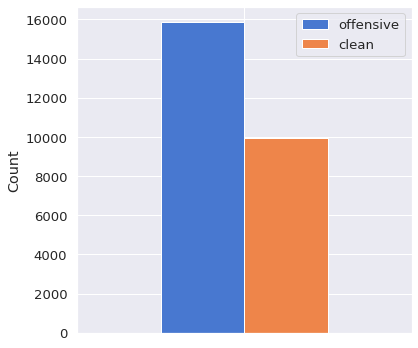

In [16]:
# Visualize the distribution of offensive and not offensive posts
size_df=pd.DataFrame(dict(offensive=[len(offensive_df)], clean=[len(not_offensive_df)]),index=[''])
fig = plt.figure(1, figsize=(6,6))
ax = plt.subplot()
ax.set_xlabel('')
ax.set_ylabel('Count')
size_df.plot.bar(ax=ax)

In [17]:
#Combine offensive dataframe and not-offensive dataframe
combined_df=pd.concat([offensive_df,not_offensive_df])
combined_df=combined_df.replace(np.nan,'',regex=True)
combined_df=combined_df.drop(['intentYN'], axis=1)

In [18]:
# Split the data into training, validation and testing sets in the ratio of 80:10:10
df_train, df_val, df_test = np.split(combined_df.sample(frac=1, random_state=42), [int(.8*len(combined_df)), int(.9*len(combined_df))])
print(len(df_train),len(df_val), len(df_test))

20628 2579 2579


In [19]:
df_train.head()

,post,targetCategory
24782,What Does a Black Person and a 6 Hour erection...,race
325,"""Just saw a trailer for #ghostinashell and the...",
16401,Love fat hoes n tight clothes n granny panties...,"body,gender"
567,As long as there are people like you left @Ben...,gender
4521,More neurons fire when I compose this sentence...,


In [20]:
# reset the index
df_train=df_train.reset_index(drop=True)
df_val=df_val.reset_index(drop=True)
df_test=df_test.reset_index(drop=True)

- **Preprocessing (1): Label transformation**

Since it is multi-label classification, it is important to encode the labels in a binary format before building the model.

In [21]:
# use get_dummies 
df_train['targetCategory'].str.get_dummies(sep=',').reset_index(drop=True).head()

,body,culture,disabled,gender,race,social,victim
0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0


In [22]:
# Transform the labels into numpy array, which will make training easier 
train_labels=df_train['targetCategory'].str.get_dummies(sep=',').reset_index(drop=True).to_numpy()

In [23]:
# Sanity check on the label transformation 
print (train_labels[0])
print (df_train['targetCategory'][0])

[0 0 0 0 1 0 0]
race


In [24]:
val_labels = df_val['targetCategory'].str.get_dummies(sep=',').reset_index(drop=True).to_numpy()
test_labels = df_test['targetCategory'].str.get_dummies(sep=',').reset_index(drop=True).to_numpy()

In [25]:
# create a list of target labels
target_labels=df_train['targetCategory'].str.get_dummies(sep=',').reset_index(drop=True).columns.tolist()
target_labels

['body', 'culture', 'disabled', 'gender', 'race', 'social', 'victim']

In [26]:
# Visualize the distribution of 'targetCategory' in the dataset
dist_target_Category=combined_df['targetCategory'].str.get_dummies(sep=',').reset_index(drop=True)

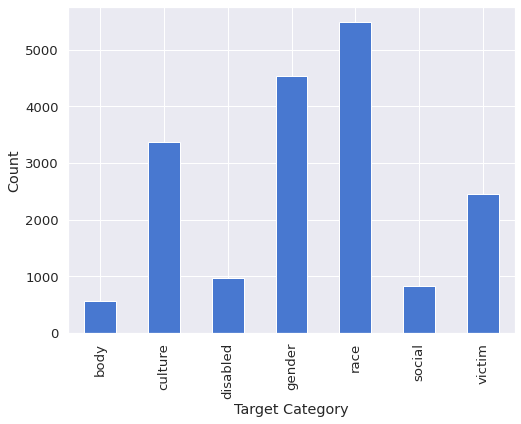

In [27]:
fig = plt.figure(1, figsize=(8,6))
ax = plt.subplot()
ax.set_xlabel('Target Category')
ax.set_ylabel('Count')
dist_target_Category.sum(axis=0).plot.bar(ax=ax)

- **Preprocessing (2): Text preprocessing**

Text preprocessing procedure is different for the baseline model and the BERT classifier. Therefore, this section will only mention the preprocessing for the baseline model. The BERT classifier preprocessing will be discussed in Section 7: Classification approach. 

Since the dataset consists of social media posts, removing noise first, such as symbols and escapes characters, is important. Hence, the text preprocessing steps are: lowercase the text => remove special characters => tokenize the text => lemmatize the text => remove stop words. After the text is cleaned with the steps above, it is transformed into feature vectors with TfidfVectorizer.
- Tokenization is an essential preprocessing step. It breaks down a text into smaller units/tokens, and those tokens can be directly transformed into different vector representations, which are suitable for machine learning. 
- Lemmatization is used here instead of stemming. Stemming attempts to reduce a word to its stem, but over-stemming is a common issue. For example, passing "properties" into Snowballstemmer in nltk returns "properti". Lemmatization is more rule-based complex stemming. It converts the word to its meaningful base form. When passing through “properties”, it will return “property”.
- TF-IDF method is chosen because compared with another form of text representation (like bag of words), TF-IDF distinguishes very common words or rare words. TF-IDF considers not just the occurrence of a word in a single document but in the entire corpus.



In [28]:
stop_words = set(stopwords.words('english'))
character = re.compile('[/(){}\[\]\|@,;]')
symbols = re.compile('[^0-9a-z #+_]')

wordnet_lemmatizer = WordNetLemmatizer()

def tokenize_lemma_stopwords(text):
    text = text.lower() # lowercase text
    text = character.sub(' ', text) # replace character and symbols in the text
    text = symbols.sub(' ', text) 
    tokens = nltk.tokenize.word_tokenize(text.lower()) # tokenize the text
    tokens = [t for t in tokens if t.isalpha()] # keep strings with only alphabets
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words into base form
    tokens = [t for t in tokens if len(t) > 2] # remove short words, they're probably not useful
    tokens = [t for t in tokens if t not in stop_words] # remove stopwords
    cleanedText = " ".join(tokens)
    return cleanedText

def dataCleaning(df):
    data = df.copy()
    data["post"] = data["post"].apply(tokenize_lemma_stopwords)
    return data

In [29]:
clean_train_df = dataCleaning(df_train)
clean_test_df = dataCleaning(df_test)

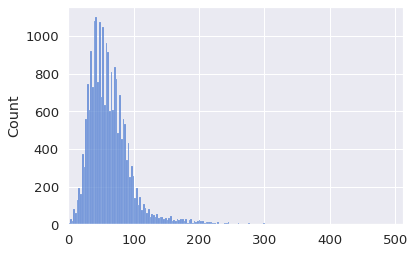

In [30]:
# Visualize the lnumber of tokens per post in the training and testing sets
token_counts_baseline = []
for i in range (0, len(clean_train_df)):
    token_count =len(clean_train_df.post[i])
    token_counts_baseline.append(token_count)
for i in range (0, len(clean_test_df)):
    token_count =len(clean_test_df.post[i])
    token_counts_baseline.append(token_count)
sns.histplot(token_counts_baseline)
plt.xlim([0, 512]);

In [31]:
# vectorize the post with TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorised_train_documents = vectorizer.fit_transform(clean_train_df["post"])
vectorised_test_documents = vectorizer.transform(clean_test_df["post"])

#### 6. Baseline model and performance: One-vs-rest logistic regression

For handling multi-label classification, there are two ways: problem transformation methods and algorithm adaptation methods. Problem transformation methods treat multi-label problems as a set of binary classifications. Algorithm adaptation adapts the algorithms, which can directly apply to multi-label classification. For example, multi-label version of kNN is represented by MLkNN.

As one of the problem transformation methods, one-vs-rest logistic regression is chosen to build a baseline model. One-vs-rest method essentially transforms a multi-label problem into multiple single-label problems. With this strategy, multiple independent binary classifiers are built. Logistic regression is chosen here as an estimator instead of Naïve Bayes, widely used in text classification. It has been shown shown that the conventional Naïve Bayes classifier sees each label independently and neglects its relations (Kim et al., 2020). Hence, for multi-label classification, Naïve Bayes often results in degraded accuracy. Naïve Bayes classification was also experimented with in this project. The results align with the literature. 


In [32]:
logClassifier=OneVsRestClassifier(LogisticRegression()) 
logClassifier.fit(vectorised_train_documents, train_labels)
logPreds=logClassifier.predict(vectorised_test_documents) 

In [33]:
baseline_logistic=compute_metrics("Baseline Logistic Regression", test_labels,logPreds,target_labels) 

------Baseline Logistic Regression Model Metrics-----
Accuracy: 0.6630
Hamming Loss: 0.0558
              precision    recall  f1-score   support

        body       1.00      0.06      0.11        54
     culture       0.96      0.53      0.68       328
    disabled       0.85      0.24      0.38        91
      gender       0.82      0.60      0.69       432
        race       0.93      0.68      0.79       549
      social       0.80      0.10      0.18        77
      victim       0.71      0.20      0.32       249

   micro avg       0.88      0.50      0.64      1780
   macro avg       0.87      0.35      0.45      1780
weighted avg       0.87      0.50      0.61      1780
 samples avg       0.33      0.32      0.32      1780



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
# Experiment with one-vs-rest multinominal Naive Bayes
nbClassifier = OneVsRestClassifier(MultinomialNB())
nbClassifier.fit(vectorised_train_documents, train_labels)
nbPreds = nbClassifier.predict(vectorised_test_documents)
compute_metrics("Naive Bayes", test_labels,nbPreds,target_labels)

------Naive Bayes Model Metrics-----
Accuracy: 0.4568
Hamming Loss: 0.0887
              precision    recall  f1-score   support

        body       0.00      0.00      0.00        54
     culture       0.93      0.12      0.21       328
    disabled       0.00      0.00      0.00        91
      gender       0.95      0.08      0.15       432
        race       0.95      0.21      0.34       549
      social       0.00      0.00      0.00        77
      victim       1.00      0.00      0.01       249

   micro avg       0.95      0.11      0.19      1780
   macro avg       0.55      0.06      0.10      1780
weighted avg       0.83      0.11      0.18      1780
 samples avg       0.07      0.07      0.07      1780



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


- **Baseline Performance**

Though the results are considerably better than Naive Bayes classifier, baseline logistic regression shows only about 65% accuracy with high precision and low recall. It is a multi-label classification task on a challenging dataset. There is potential an underlying relationship between target categories, which can make the labelling task difficult for both human and machine. Nonetheless, there might some improvements can still be made. 

#### 7. Classification approach: build a classifier with BERT and PyTorch Lightning 
Transformer is an encoder-decoder architecture that only relies on an attention mechanism to draw global dependencies between input and output (Devlin et al, 2018; Vaswani et al., 2017). As implied in its name (Bidirectional Encoder Representations from Transformers), BERT uses Transformer encoder blocks. Each encoder block consists of two modules: a self-attention layer and a feed-forward layer (ibid.). After the input text goes through tokenization, it will first pass through a multi-headed attention layer and then a feed-forward layer. Multi-headed attention computes attention different times with different weight matrices and then concatenates the results, depending on how many attention heads are there. It allows the model to associate each word in the input to another. The feed forward layer makes each attention matrix into an acceptable form by the subsequent encoders. 

There are different variation BERT models. Some handle different languages and some have different numbers of parameters. BERT large model is used in this project to build the classification model. The architecture of the BERT large model consists of 24 layers of encoder blocks, 16 attention heads and 340M parameters. BERT is a powerful NLP model with wide range of application. For example, it can be used for text summarization and question answering; Facebook also used RoBERTa (a variation of BERT) to detect harmful context (text classification task)(Kiela et al., 2020). BERT is chosen for this project. First, it is pretrained on a large corpus. Also, BERT learns information with no specific direction by taking into account the surrounding context. Hence, it does a better job at understanding the text than previous NLP methodologies. For example, previous language models such as word2vec and GloVe have limitations in interpreting context and polysemous words.


- **Preprocessing: with BertTokenizer**

BERT expects input as a sequence of tokens. There are two special tokens that are part of BERT's design: [CLS] and [SEP]. [CLS] is the first token of every sequence. [SEP] lets BERT understand which token belongs to which sentence. This token is more important in the next sentence prediction. 

Another important thing about the BERT model is that the maximum size of tokens it can take is 512. If the tokens in a sequence are less than 512, [PAD] token can be used to pad the unused token slots. Since the dataset is mainly social media posts in this project, the maximum size will not be an issue. 

In [35]:
ber_model_name = "bert-large-uncased" 

In [36]:
# An example with one of the text
example=df_train.post[15]
tokenizer = BertTokenizer.from_pretrained(ber_model_name)
bert_input = tokenizer(example,padding='max_length', max_length = 15, truncation=True, return_tensors="pt")

# Each token was given a unqiue ID 
print(bert_input['input_ids'])

# Attention mask informs the model which tokens should be paid attention to and which should not (1 - use; 0 - don't use).
print(bert_input['attention_mask'])

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

tensor([[  101,  2339,  2987,  1005,  1056,  1996, 20014,  1012,  2451,  2202,
          1001,  4632,  4215,  2000,   102]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [37]:
example_text = tokenizer.decode(bert_input.input_ids[0])
print(example_text)
print(df_train.post[15])

[CLS] why doesn't the int. community take # assad to [SEP]
Why doesn't the int. community take #Assad to the #haguecourt to be tried for war crimes? Why does #Trumprussia deflect by bombing #Syria


In [38]:
# Visualize the length of the posts after going through BertTokenizer
token_counts = []

for _, row in complete_df.iterrows():
    token_count = len(tokenizer.encode(
    row["post"], 
    max_length=512, 
    truncation=True
  ))
    token_counts.append(token_count)

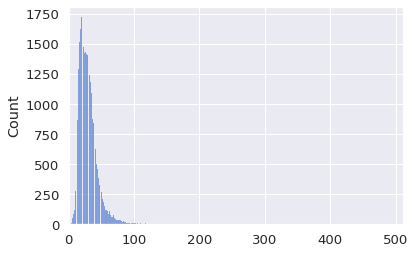

In [39]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

As the figure above shows, most posts contain less than 125 tokens. Hence, in this project, the maximum size of tokens passing through the model will be 128. If a sequence is longer than 128 tokens, it will be truncated.

- **Model building**

In [40]:
# BiasDataset class is created based on the PyTorch Dataset class,which transfers the text in a format needed for the BERT Model
# __init__, __len__, and __getitem__ functions are required to initialize the class

class SocialBiasDataset (Dataset):
    def __init__(self, post, targetCategory, tokenizer, max_len=128):
        '''
        The constructor initiatlises the instances with a set of parameters:  
        '''
        self.post = post
        self.targetCategory = targetCategory
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        '''
        This function returns the number of samples in the dataset
        '''
        return len(self.post)
    
    def __getitem__(self, item_idx):
        '''
        This function loads a sample form the dataset at the given index (item_idx)
        - returns:
        the 'input_ids' and 'attention_mask' of the tokenized text
        accodring labels in torch.tensor format.
        '''
        text = self.post[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiate which tokens to pay attention to 
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        #convert in one-dimension
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        
        return {
            'text':text,
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'labels': torch.tensor(self.targetCategory[item_idx], dtype=torch.float)
        }
        

In [41]:
# Sanity check on how the dataset module works by looking at one example item
train_dataset = SocialBiasDataset(df_train.post,train_labels,tokenizer,max_len=128)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [42]:
print(sample_item['text'])
print(sample_item['labels'])
print(df_train.post[0])
print(train_labels[0])

What Does a Black Person and a 6 Hour erection have in common? If they don't go away you have seek immediately help
tensor([0., 0., 0., 0., 1., 0., 0.])
What Does a Black Person and a 6 Hour erection have in common? If they don't go away you have seek immediately help
[0 0 0 0 1 0 0]


In [43]:
# SocialBiasDataModule class is created based on the PyTorch LightningDataModule API
# The module is a collection of a train_dataloader, val_dataloader, test_dataloader for preparing the data required 

class SocialBiasDataModule (pl.LightningDataModule):
    def __init__(self,train_post,train_label,val_post,val_label,test_post,test_label,tokenizer,batch_size=16,max_len=128):
        super().__init__()
        self.train_post = train_post
        self.train_label = train_label
        self.val_post = val_post
        self.val_label = val_label
        self.test_post = test_post
        self.test_label = test_label
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_len = max_len
        
    def setup(self, stage=None):
        self.train_dataset= SocialBiasDataset(post=self.train_post,targetCategory=self.train_label, tokenizer=self.tokenizer,max_len = self.max_len)
        self.val_dataset  = SocialBiasDataset(post=self.val_post,targetCategory=self.val_label,tokenizer=self.tokenizer,max_len = self.max_len)
        self.test_dataset = SocialBiasDataset(post=self.test_post,targetCategory=self.test_label,tokenizer=self.tokenizer,max_len = self.max_len)
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= self.batch_size, num_workers=2)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= self.batch_size, num_workers=2)

In [44]:
# Initialize the parameters that will be use for training
batch_size = 16
max_len = 128
lr=1e-4
n_epochs = 12
n_classes=len(target_labels)

# Instantiate and set up the datamodule
data_module = SocialBiasDataModule(
    df_train.post,train_labels,
    df_val.post,val_labels,
    df_test.post,test_labels,
    tokenizer,batch_size,max_len)

- **Train the model**

The model uses a pre-trained BertModel and a linear layer to convert the BERT representation to a classification task. The classifier is set up using LightningModule.

Most of the implementation follows the boilerplate from the LightningModule. However, there are two points of interest:

-  BCEWithLogitsLoss is used as loss calculation. It combines a sigmoid layer and the BCE loss in a single class. This version is numerically more stable than BCE loss. 

- optimizer: AdamW is chosen as the optimizer, which is the improved version of Adam. The weight decay is performed only after controlling the parameter-wise step size. The configuration of the optimizers also includes warming steps. Warming steps mean starting with a slow learning rate. It can help tune attention mechanisms in the network.


In [45]:
class SocialBiasClassifier(pl.LightningModule):
    def __init__(self, n_classes, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()
        self.bert = BertModel.from_pretrained(ber_model_name, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # n_classes = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss() 
        
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = self.classifier(output.pooler_output)
        return output
    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log("train_loss", loss, prog_bar=True, logger=True, on_epoch=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}
    
    
    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True, on_epoch=True)
        
        return loss

    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True, on_epoch=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)  
        warmup_steps = self.steps_per_epoch//3   # Set up the first 1/3 steps as warm up step.
        training_steps = self.steps_per_epoch * self.n_epochs - warmup_steps
        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,training_steps)

        return [optimizer], [scheduler]
    
    

In [46]:
# Instantiate the classifier model
steps_per_epoch = len(df_train.post)//batch_size
model = SocialBiasClassifier(n_classes=n_classes, steps_per_epoch=steps_per_epoch,n_epochs=n_epochs,lr=lr)

Downloading:   0%|          | 0.00/1.25G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
# Initialize Pytorch Lightning callback for Model checkpointing

checkpoint_callback = ModelCheckpoint(
  filename="best-checkpoint",
  save_top_k=1, # save the top 1 model
  monitor="val_loss", # monitoring based on validation loss
  mode="min"
)

In [48]:
# Instantiate the mdoel trainer
trainer = pl.Trainer(max_epochs = n_epochs , gpus = 1, callbacks=[checkpoint_callback],progress_bar_refresh_rate = 30)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [49]:
# Train the classifier
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 335 M 
1 | classifier | Linear            | 7.2 K 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
335 M     Trainable params
0         Non-trainable params
335 M     Total params
1,340.596 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [64]:
# Evaluate the model performance
trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.10871358215808868}
--------------------------------------------------------------------------------


[{'test_loss': 0.10871358215808868}]

In [65]:
# Retreive the checkpoint path for best model
model_path = checkpoint_callback.best_model_path
model_path

'/content/lightning_logs/version_0/checkpoints/best-checkpoint.ckpt'

In [52]:
# Load the best version (based on validation loss) of the model:
trained_model = SocialBiasClassifier.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=n_classes
)
trained_model.eval() #eval mode for the prediction 
trained_model.freeze() #stop training the model 

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- **Set up the test set**

In [66]:
input_ids = []
attention_masks = []
#Tokenize the test set
for post in df_test.post:
    encoded_post =  tokenizer.encode_plus(
                    post,
                    add_special_tokens=True,
                    max_length= max_len,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded question to the list.    
    input_ids.append(encoded_post['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_post['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(test_labels)


# Create the DataLoader on the test set
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=batch_size)

- **Predict the test set**

In [54]:
trained_model = trained_model.to(device) # moving model to cuda
trained_model.eval()


pred_outs, true_labels = [], []
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

    pred_outs.append(pred_out)
    true_labels.append(label_ids)

In [55]:
flat_pred_outs = 0
flat_true_labels = 0

In [56]:
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [57]:
# Sanity check
flat_pred_outs.shape , flat_true_labels.shape

((2579, 7), (2579, 7))

In [58]:
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,threshold):
    y_pred = []
    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= threshold:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)
    return y_pred

In [59]:
# prediction based on threshold 
y_pred_labels = classify(flat_pred_outs,0.5)

# return flatten arrays
y_pred = np.array(y_pred_labels).ravel() 
y_true = flat_true_labels.ravel() 

In [60]:
# Turn the array into according labels 
def array_to_label (array, n_classes):
    category=[]
    for x in range (0, len(array)):
        category.append([])
        for i in range (0,n_classes):
          if array[x][i]==1:
              category[x].append(target_labels[i])
    return category


In [61]:
pred_label=array_to_label (y_pred_labels, n_classes)
true_label=array_to_label (test_labels, n_classes)

In [62]:
# Create a dataframe based on the test set with actual labels and predicted labels side by side
df_test_with_predicted_tags = pd.DataFrame({'Post':df_test.post,'Actual Labels':true_label,'Predicted Labels':pred_label})
df_test_with_predicted_tags

,Post,Actual Labels,Predicted Labels
0,How many secretive people does it take to chan...,[],[race]
1,A woman in 2x is experiencing what a lot of me...,[gender],[gender]
2,Reminder that a woman of any genetic combinati...,[gender],[gender]
3,Why is a computer better than a woman? You onl...,[gender],[gender]
4,blast the music until u can't feel a fucking t...,[],[]
5,"If you don't like it, you can return it. I jus...",[],[]
6,Lionel Richie often alters his songs when he's...,[race],[]
7,Gays are an important part of any military. Yo...,[gender],[gender]
8,When I was younger I used to think I'd always ...,[],[]
9,i was watching this dumb ass horror/comedy mov...,[],[]


In [63]:
# Evaluate the Bert classifier, side by side with the baseline logistic model
bert_eval=compute_metrics("Bert", flat_true_labels,y_pred_labels,target_labels)
baseline_logistic=compute_metrics("Baseline Logistic Regression", test_labels,logPreds,target_labels) 

------Bert Model Metrics-----
Accuracy: 0.7747
Hamming Loss: 0.0402
              precision    recall  f1-score   support

        body       0.73      0.15      0.25        54
     culture       0.85      0.81      0.83       328
    disabled       0.83      0.84      0.83        91
      gender       0.79      0.85      0.82       432
        race       0.89      0.84      0.87       549
      social       0.65      0.42      0.51        77
      victim       0.76      0.46      0.57       249

   micro avg       0.83      0.74      0.79      1780
   macro avg       0.79      0.62      0.67      1780
weighted avg       0.82      0.74      0.77      1780
 samples avg       0.48      0.47      0.47      1780

------Baseline Logistic Regression Model Metrics-----
Accuracy: 0.6630
Hamming Loss: 0.0558
              precision    recall  f1-score   support

        body       1.00      0.06      0.11        54
     culture       0.96      0.53      0.68       328
    disabled       0.85   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

#### 9. Evaluation 

The evaluation of the BERT classifier shows a decent result considering the challenging task in multi-labelling. Accuracy is 77% with 4% hamming loss. It means about 4% of the all the predicted labels are incorrect. Overall, the evaluation shows high recall (micro average: 74%) and high precision (micro average: 83%). There is also a noticeable improvement compared with the baseline model. The overall accuracy increased from 66% to 77%, which is an absolute improvement of 11% and relative improvement by 18%. The hamming loss dropped from 5.5% to 4%, which is an absolute improvement of 1.7% and relative improvement of 30% (for hamming loss, the lower the better). 

Looking into the performance of individual classes, other than body, BERT classifier improves the recall of each category, with a slight drop in precision. BERT classifier also shows promising result in major categories (*race, gender and culture*). Interestingly, both BERT classifier and baseline model struggle to have good precision and recall on the *body* category. It is possible that there are less training samples for the body category. 


#### 10. Summary and conclusion 

With BERT large model, this project successfully constructs a multi-label classifier on predicting offensive social media post and the classifier reaches almost 80% accuracy on the test set. Creating a "fair" offensive language detection model requires a well annotated dataset. The classifier built on SBIC can contribute to identifying offensive language and its target categories. 

Overall results of the classifier are satisfying but the model predictions on minor target categories (*body, social and victim*) need improvement. Techniques such as random oversampling and undersampling could be considered in the future. The current method of preprocessing for BERT classifier (passing through raw text directly into classifier) seems to be effective. However, removing escape characters and numbers in the text might improve the accuracy. 

The current classifier is suitable for short social media posts. With modification, the classifier can potentially detect hate speech or content that people may find offensive before publishing. 

The project uses BERT large model and PyTorch Lightning to build the classifier. A few alternative approaches can achieve the same goal: (1) There are other transformer pre-trained models that are more powerful than BERT, such as GPT2 and GPT Neo. Training the dataset on these models could yield better results, because they have more parameters. However, it will also require more training time or computing power. (2)  BERT can also be loaded through Tensorflow. PyTorch Lightning is more user friendly, and it is more intuitive to build models. However, Tensorflow is better supported with bigger communities.  



### **Bibliography**

Breitfeller, L., Ahn, E., Jurgens, D., & Tsvetkov, Y. (2019, November). Finding microaggressions in the wild: A case for locating elusive phenomena in social media posts. In *Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing and the 9th International Joint Conference on Natural Language Processing (EMNLP-IJCNLP)* (pp. 1664-1674).

Davidson, T., Warmsley, D., Macy, M., & Weber, I. (2017, May). Automated hate speech detection and the problem of offensive language. In *Proceedings of the International AAAI Conference on Web and Social Media*(Vol. 11, No. 1).

Davidson, T., Bhattacharya, D., & Weber, I. (2019). Racial bias in hate speech and abusive language detection datasets. *arXiv preprint arXiv:1905.12516.*

Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding.* arXiv preprint arXiv:1810.04805.*

Kim, H. C., Park, J. H., Kim, D. W., & Lee, J. (2020). Multilabel naïve Bayes classification considering label dependence. *Pattern Recognition Letters, 136*, 279-285.

Kiela, D., Firooz, H., Mohan, A., Goswami, V., Singh, A., Ringshia, P., & Testuggine, D. (2020). The hateful memes challenge: Detecting hate speech in multimodal memes. *arXiv preprint arXiv:2005.04790.*

Lee, S. I., Lee, H., Abbeel, P., & Ng, A. Y. (2006, July). Efficient l~ 1 regularized logistic regression. In *Aaai* (Vol. 6, pp. 401-408).

Sap, M., Card, D., Gabriel, S., Choi, Y., & Smith, N. A. (2019, July). The risk of racial bias in hate speech detection. In *Proceedings of the 57th annual meeting of the association for computational linguistics* (pp. 1668-1678).

Sap, M., Gabriel, S., Qin, L., Jurafsky, D., Smith, N. A., & Choi, Y. (2020). Social bias frames: Reasoning about social and power implications of language. *arXiv preprint arXiv:1911.03891*

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł. & Polosukhin, I. (2017). Attention is all you need. In *Advances in neural information processing systems* (pp. 5998-6008).

Waseem, Z., & Hovy, D. (2016, June). Hateful symbols or hateful people? predictive features for hate speech detection on twitter. In *Proceedings of the NAACL student research workshop* (pp. 88-93).
